# Code to analyze the progressive blackjack side bet. 
## Premise of game: 
### 1. Costs $5 to play. 
### 2. Pays out if the player's hand and dealer's hand combines for a royal flush AND the dealer has blackjack. 
### 3. Royal flush of diamonds pays out the entire meter and other suits pay out 10% of it. 
Author: Evan Tsiklidis

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from blackjack_sidebet_sim import Blackjack_shoe
import os
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, ensemble
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
cards = ['ace','king','queen','jack','ten','nine','eight','seven','six','five','four','three','two']
suits = ['spades','hearts','clubs','diamonds']

In [3]:
counting_df = pd.read_csv(os.getcwd()+'/counting_systems/high_low_blackjack.csv').drop(['Unnamed: 0'],axis=1)
counting_df.head()

,Card,Value
0,ace_of_spades,-1
1,ace_of_hearts,-1
2,ace_of_clubs,-1
3,ace_of_diamonds,-1
4,king_of_spades,-1


In [4]:
counting_rules = dict(zip(counting_df.Card, counting_df.Value))
small_cards = counting_df[counting_df['Value']>0].Card.tolist()

In [5]:
run_sims_flag = False
num_sims = 1000000
jackpot = 800000
cost_to_play = 5
win_counter = 0
avg_rt = num_sims*30/3600 #assume 60 seconds/hand in real life. 

In [6]:
if run_sims_flag == True: 
    num_decks_list = [8,7,6,5,4,3,2,1]
    matrix = []
    for num_decks in num_decks_list: 
        data = []
        expectation = -1*num_sims*5
        for running_count in range(4*5*num_decks):  
            shoe = Blackjack_shoe(num_decks_remaining=num_decks,running_count=running_count,\
                            counting_rules=counting_rules,small_cards=small_cards,win_counter=0)        
            for j in range(num_sims): 
                shoe.create_shoe()
                shoe.establish_count()
                shoe.evaluate_jackpot()
            shoe.summarize_results()
            num_wins = shoe.get_expectation_ranges()
            data = [num_decks,running_count,num_wins]
            matrix.append(data)
    df = pd.DataFrame(matrix,columns = ['num_decks','running_count','num_wins'])
    df.to_csv(os.getcwd()+'/counting_systems/simulated_results1.csv')
    df.head()

In [7]:
df = pd.read_csv(os.getcwd()+'/counting_systems/simulated_results1.csv').drop(['Unnamed: 0'],axis=1)
df.head()

,num_decks,running_count,num_wins
0,8,0,9
1,8,1,6
2,8,2,4
3,8,3,4
4,8,4,9


In [8]:
df['Expected_Cash_Return']=(df['num_wins']*jackpot*(0.25+0.025+0.025+0.025)) - num_sims*cost_to_play
df['avg'] =  df['Expected_Cash_Return']/avg_rt
df.head()

,num_decks,running_count,num_wins,Expected_Cash_Return,avg
0,8,0,9,-2660000.0,-319.2
1,8,1,6,-3440000.0,-412.8
2,8,2,4,-3960000.0,-475.2
3,8,3,4,-3960000.0,-475.2
4,8,4,9,-2660000.0,-319.2


In [9]:
df['True_Count'] = df['running_count']/df['num_decks']
df.head()

,num_decks,running_count,num_wins,Expected_Cash_Return,avg,True_Count
0,8,0,9,-2660000.0,-319.2,0.000
1,8,1,6,-3440000.0,-412.8,0.125
2,8,2,4,-3960000.0,-475.2,0.250
3,8,3,4,-3960000.0,-475.2,0.375
4,8,4,9,-2660000.0,-319.2,0.500


## Let's take a look at the data for various jackpot / True Count values. Perhaps unexpectedtly, some natural variability shown in each plot since this is still a stochastic process. 

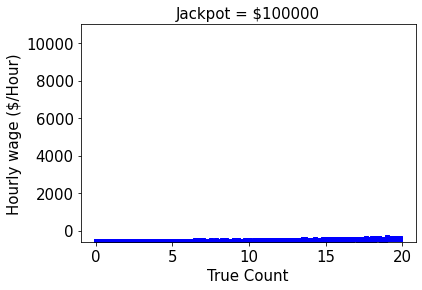

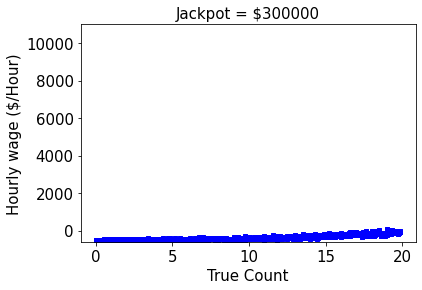

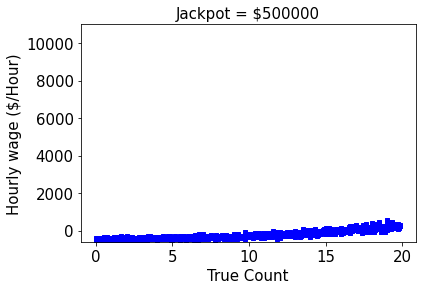

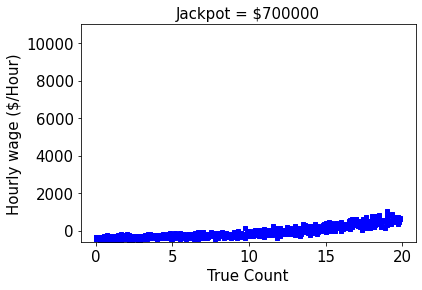

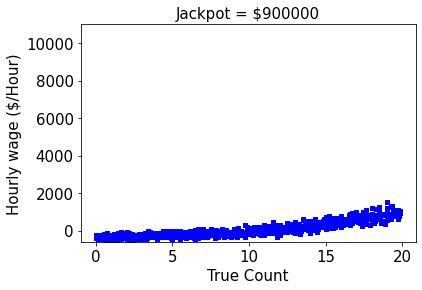

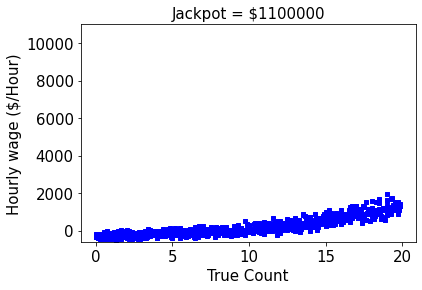

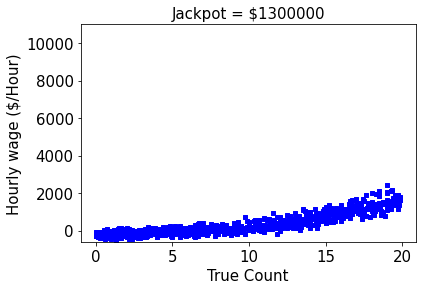

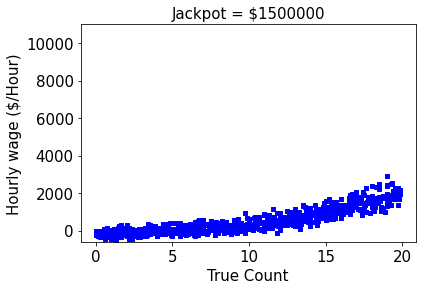

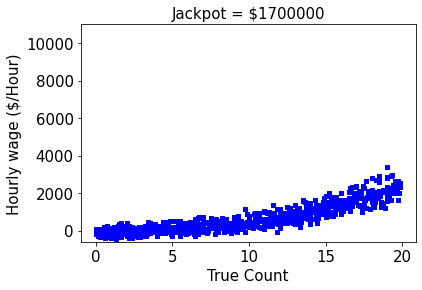

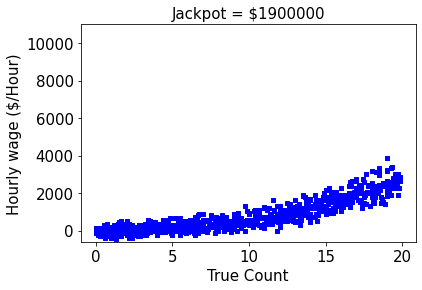

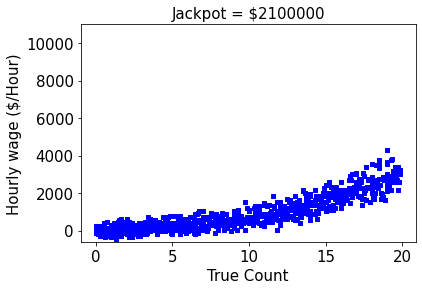

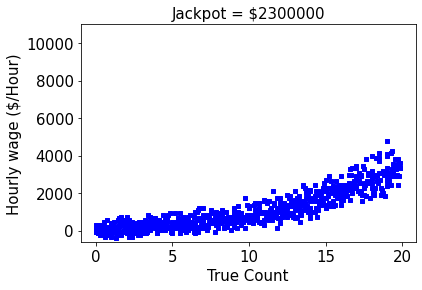

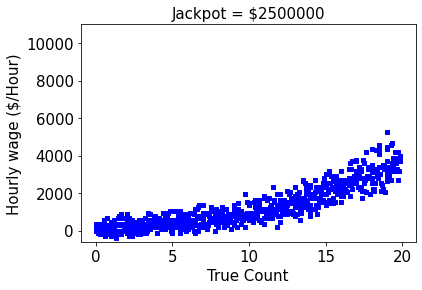

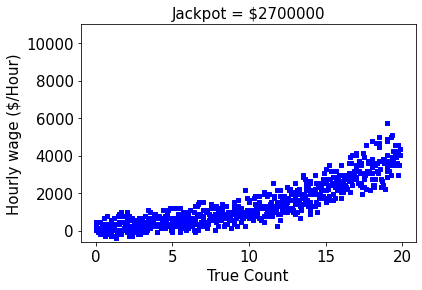

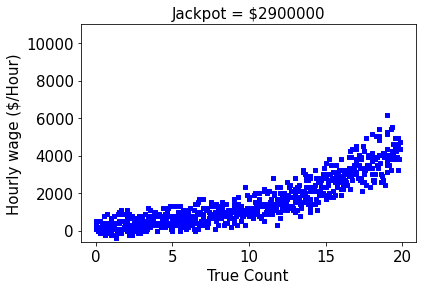

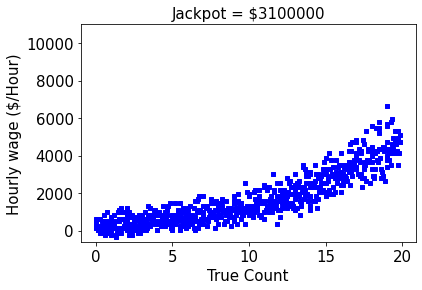

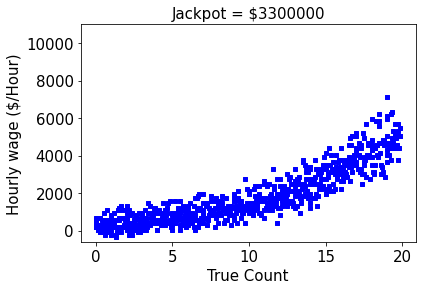

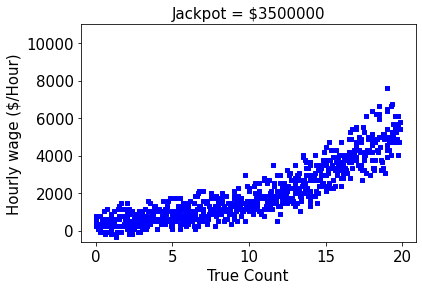

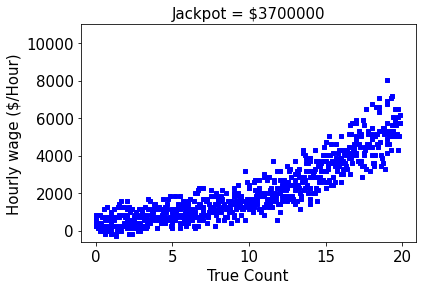

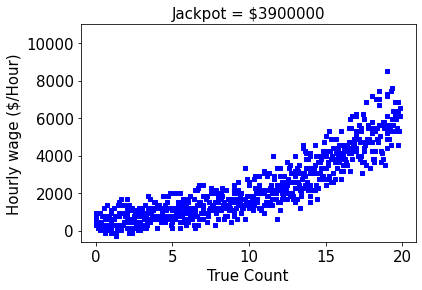

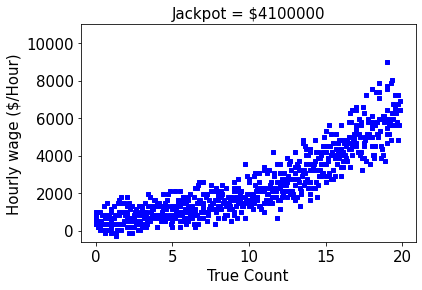

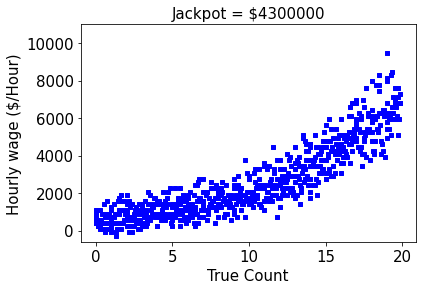

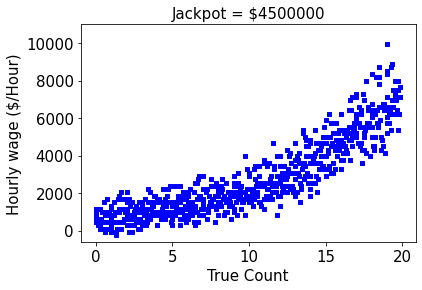

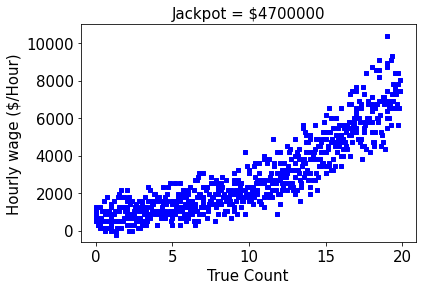

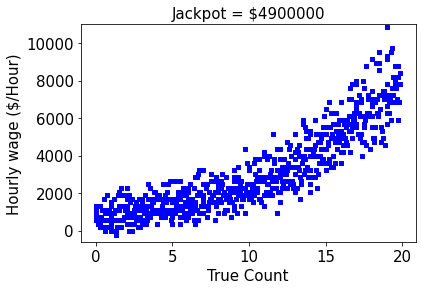

In [10]:
jackpot_list = np.arange(100000,5100000,200000)
df_final = pd.DataFrame({})
for jackpot in jackpot_list: 
    df['Expected_Cash_Return']=(df['num_wins']*jackpot*(0.25+0.025+0.025+0.025)) - num_sims*cost_to_play
    df['jackpot_value'] = jackpot
    df['avg'] =  df['Expected_Cash_Return']/avg_rt
    df['True_Count'] = df['running_count']/df['num_decks']
    df_final = pd.concat([df_final,df])
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(df.True_Count, df.avg, s=20, c='b', marker="s")
    ax1.tick_params(axis='both', which='major', labelsize=15)
    plt.ylim([-600, 11000])
    plt.ylabel('Hourly wage ($/Hour)',fontsize=15)
    plt.xlabel('True Count',fontsize=15)
    plt.title('Jackpot = $' + str(jackpot),fontsize=15)
    plt.show()    

In [11]:
df_final.head()

,num_decks,running_count,num_wins,Expected_Cash_Return,avg,True_Count,jackpot_value
0,8,0,9,-4707500.0,-564.9,0.000,100000
1,8,1,6,-4805000.0,-576.6,0.125,100000
2,8,2,4,-4870000.0,-584.4,0.250,100000
3,8,3,4,-4870000.0,-584.4,0.375,100000
4,8,4,9,-4707500.0,-564.9,0.500,100000


## Now let's train an ML model to smooth out the results and be able to predict an hourly rate at specific jackpot values and true counts. 

In [12]:
X = df_final[['True_Count','jackpot_value']]
y = df_final[['avg']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

params = {
    "n_estimators": 5000,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.001,
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

/Users/evan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingRegressor(learning_rate=0.001, max_depth=4, min_samples_split=5,
                          n_estimators=5000)

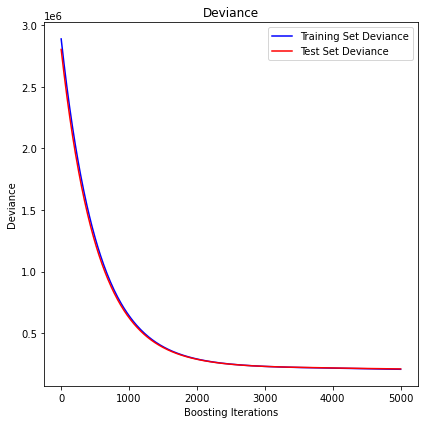

In [13]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Plotting model predictions against true values, we can see that the model does exactly what we would like it to do: it creates a smooth function that can be used to compute an expected hourly return rate given certain conditions. 

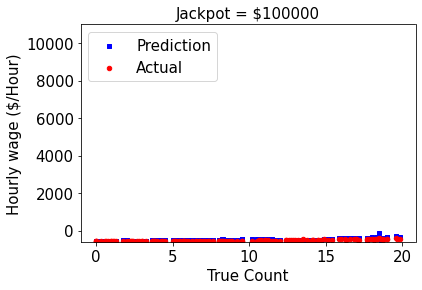

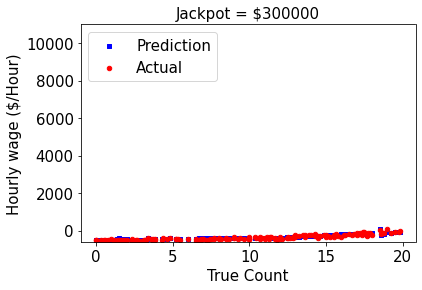

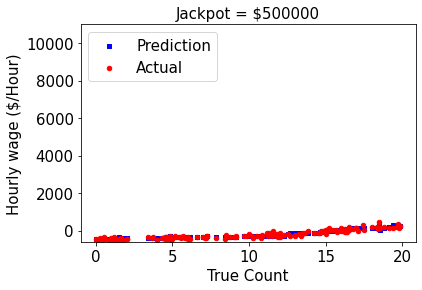

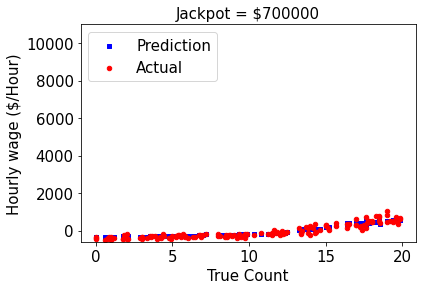

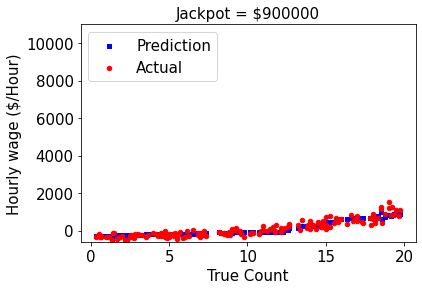

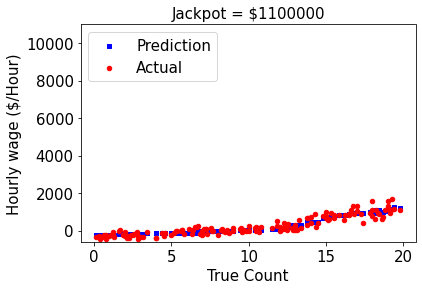

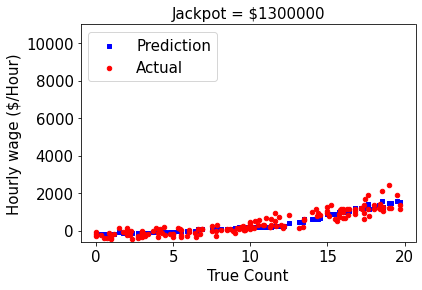

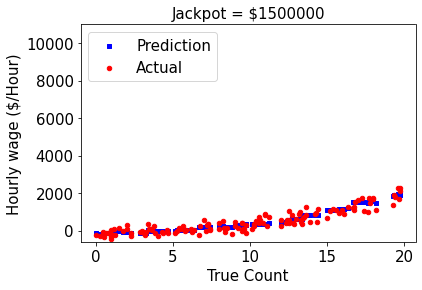

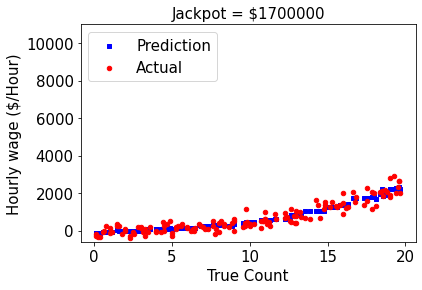

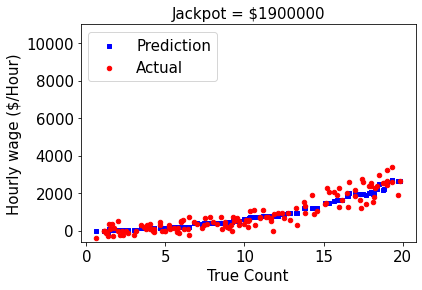

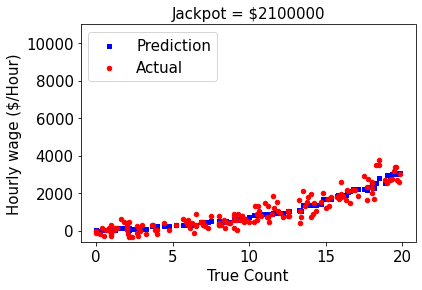

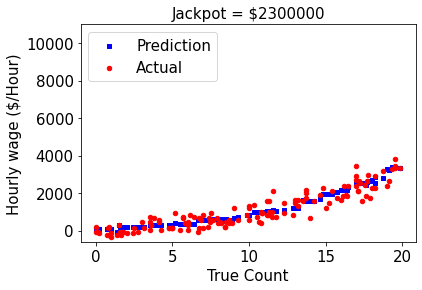

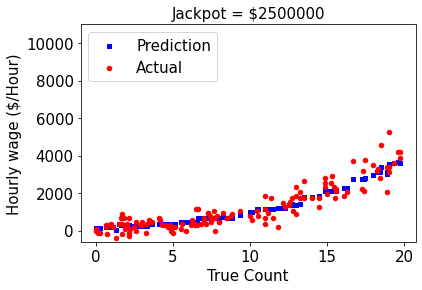

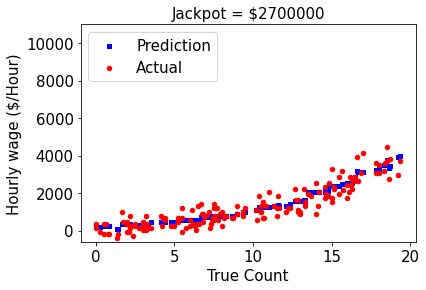

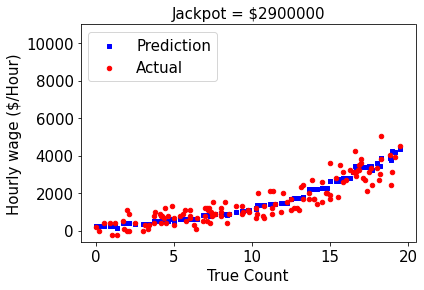

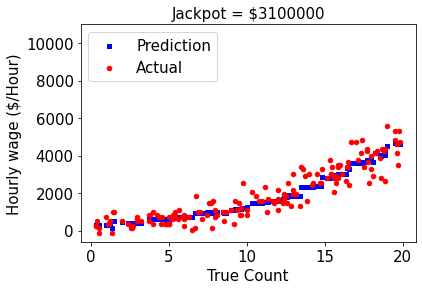

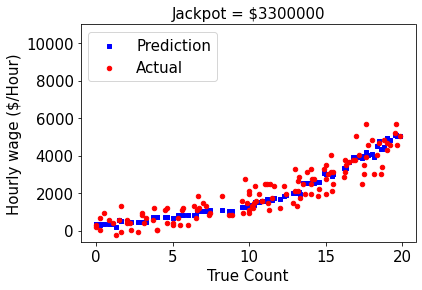

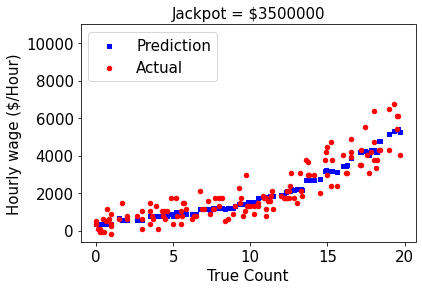

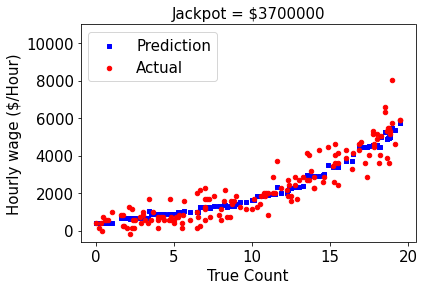

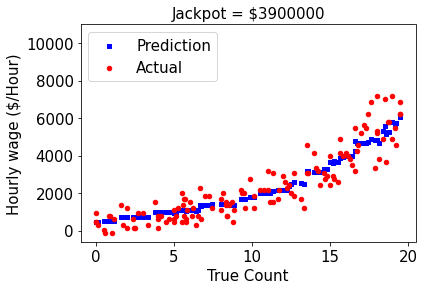

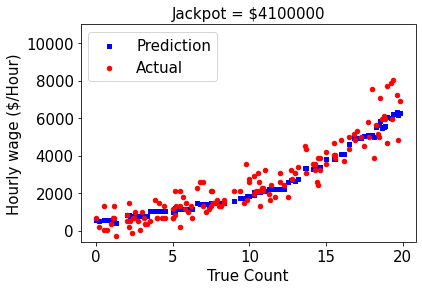

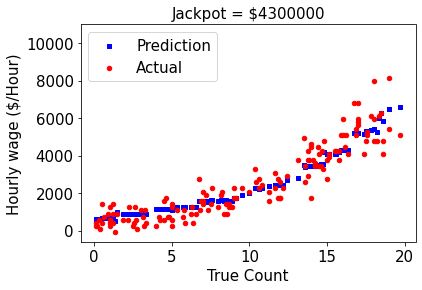

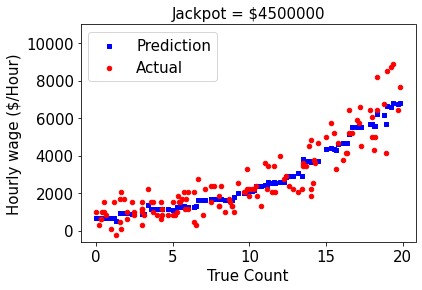

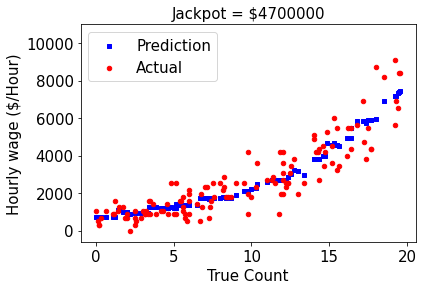

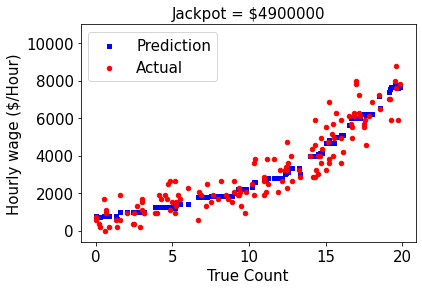

In [14]:
for jackpot in jackpot_list: 
    temp = pd.concat([X_test,y_test],axis=1)
    temp = temp[temp['jackpot_value'] == jackpot]
    X_test_exp = temp[['True_Count','jackpot_value']]
    y_pred = reg.predict(X_test_exp).tolist()
    y_test_exp = temp['avg'].tolist()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.scatter(X_test_exp.True_Count, y_pred, s=20, c='b', marker="s", label='Prediction')
    ax1.scatter(X_test_exp.True_Count,y_test_exp, s=20, c='r', marker="o", label='Actual')
    ax1.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(loc='upper left',fontsize=15)
    plt.ylim([-600, 11000])
    plt.ylabel('Hourly wage ($/Hour)',fontsize=15)
    plt.xlabel('True Count',fontsize=15)
    plt.title('Jackpot = $' + str(jackpot),fontsize=15)
    plt.show()

## This analysis is perfect if we are constantly playing the game at these conditions. We must multiply the expected value by the frequency with which these conditions occur. 

In [15]:
num_decks=8
running_count = 0
freq_list = []
num_sims = 1000
time_to_finish_all_shoes = 20*num_sims / 60 # (in hours)
for i in range(0,num_sims):
    shoe = Blackjack_shoe(num_decks_remaining=num_decks,running_count=running_count,\
                counting_rules=counting_rules,small_cards=small_cards,win_counter=0)  
    shoe.create_shoe()
    freq_list = freq_list + shoe.simulate_blackjack_shoe(0.95)

In [16]:
#Simulate game num_sims times and aggregate true count situations. 
freq_df = pd.DataFrame(freq_list,columns = ['num_decks','running_count'])
freq_df['True_Count'] = freq_df['running_count'] / freq_df['num_decks']
freq_df.head()

,num_decks,running_count,True_Count
0,8,0,0.000
1,8,3,0.375
2,8,6,0.750
3,8,3,0.375
4,8,2,0.250


In [17]:
#Use value_counts to compute frequency with which these situations occur. 
freq_df = pd.DataFrame(freq_df.True_Count.value_counts()).reset_index()
freq_df.columns = ['True_Count','frequency']
freq_df.head()

,True_Count,frequency
0,0.0,2320
1,-1.0,1776
2,1.0,1677
3,-2.0,1229
4,2.0,1187


In [18]:
#Convert to fraction of hour. 
freq_df['Fraction_of_hour'] = freq_df['frequency'] /freq_df['frequency'].sum()
freq_df.head()

,True_Count,frequency,Fraction_of_hour
0,0.0,2320,0.058000
1,-1.0,1776,0.044400
2,1.0,1677,0.041925
3,-2.0,1229,0.030725
4,2.0,1187,0.029675


In [20]:
#Use moodel to compute an average expected hourly returrn under these conditions. Note that we do not place the bets 
#if the expected value is not positive. 
true_count_list = list(np.arange(0.0, 21.0, 1.0))
jackpot_sol = []
for jackpot in jackpot_list: 
    jackpot_t = [jackpot]*len(true_count_list)
    example_df = pd.DataFrame({'True_Count':true_count_list,'jackpot_list':jackpot_t})
    model_results = reg.predict(example_df).tolist()
    example_df = pd.DataFrame({'True_Count':true_count_list,'Predicted_hourly_rate':model_results})
    example_df = example_df.merge(freq_df,left_on='True_Count',right_on='True_Count',how='inner')
    example_df = example_df[example_df['Predicted_hourly_rate']>0]
    val = np.sum(np.multiply(example_df.Predicted_hourly_rate,example_df.Fraction_of_hour))
    jackpot_sol.append([jackpot,val])
results_df = pd.DataFrame(jackpot_sol,columns = ['Jackpot Value ($)','Expected Hourly Return ($/hr)'])
results_df.head(30)

,Jackpot Value ($),Expected Hourly Return ($/hr)
0,100000,0.000000
1,300000,0.000000
2,500000,0.011592
3,700000,0.074627
4,900000,0.192828
5,1100000,0.439557
6,1300000,1.700718
7,1500000,3.259675
8,1700000,6.407390
9,1900000,11.195526
